# Find the clusters
We have successfully imported the data and visualized it to get some basic knowledge about it. Now we are going to see if we can actually cluster the respondents and divide them into some sort of groups or clusters. 

## What next?
- Load the dataset
- Use TruncatedSVD for dimensionality  reduction to make it into a surprisingly informative smaller matrix
- Use KMeans to group our participants into some clusters
- Use TSNE to get coordinates for a scatterplot
- Visualize the results

### Let's get started...

In [19]:
import numpy as np
import pandas as pd
import pylab as Plot

import matplotlib.pyplot as plt
import seaborn as sns

from plotly.graph_objs import *
import plotly.plotly as py
import plotly.tools as tls

from sklearn.manifold import TSNE
import sklearn.cluster as cluster
from sklearn.cluster import KMeans
import time

%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

Import the datasets

In [8]:
big_data = pd.read_csv('big_data.csv')
print "'big_data' dataset has {} samples with {} features each.".format(*big_data.shape)

'big_data' dataset has 170842 samples with 432 features each.


In [9]:
the_data = pd.read_csv('the_data.csv')
print "'the_data' dataset has {} samples with {} features each.".format(*the_data.shape)

'the_data' dataset has 170842 samples with 83 features each.


I will use both big_data (the original dataset with all the original time entries) and the_data (where I manually merged similar time entries) to see if there is any difference in the clustering.

# Question 1
Should I be using a sparse matrix here (because there are so many zeros)? What are the benefits?

### Dimensionality reduction
There are many zeroes in our data. In this part I will use both the manually merged data ('the_data') and the dimensionality reduced data of 'big_data' where the data points have not been manually merged.

# Question 2
What bothers me here is that when I have n_components 20+ the explained_variance_ratio plot is way off. When I take it down to 10 it shows that I am only loosing less than 0.1% of the information.... can that be true? 

In [10]:
%%time

from sklearn.decomposition import TruncatedSVD 
from sklearn.preprocessing import normalize 

svd = TruncatedSVD(n_components=10)
embedded_coords = normalize(svd.fit_transform(big_data), norm='l1')

CPU times: user 7.48 s, sys: 1.42 s, total: 8.9 s
Wall time: 7.53 s


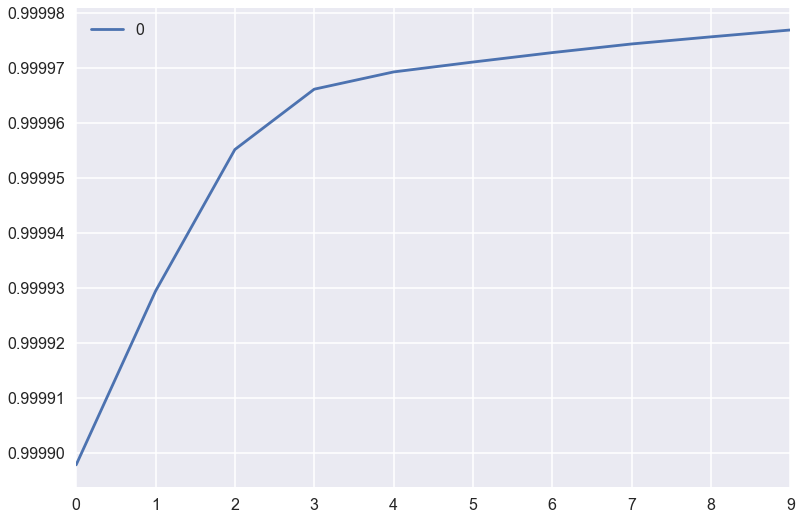

In [12]:
pd.DataFrame(np.cumsum(svd.explained_variance_ratio_)).plot()

In [13]:
%%time

from sklearn.decomposition import TruncatedSVD 
from sklearn.preprocessing import normalize 

svd1 = TruncatedSVD(n_components=5)
embedded_coords1 = normalize(svd.fit_transform(the_data), norm='l1')

CPU times: user 2.79 s, sys: 473 ms, total: 3.27 s
Wall time: 2.73 s


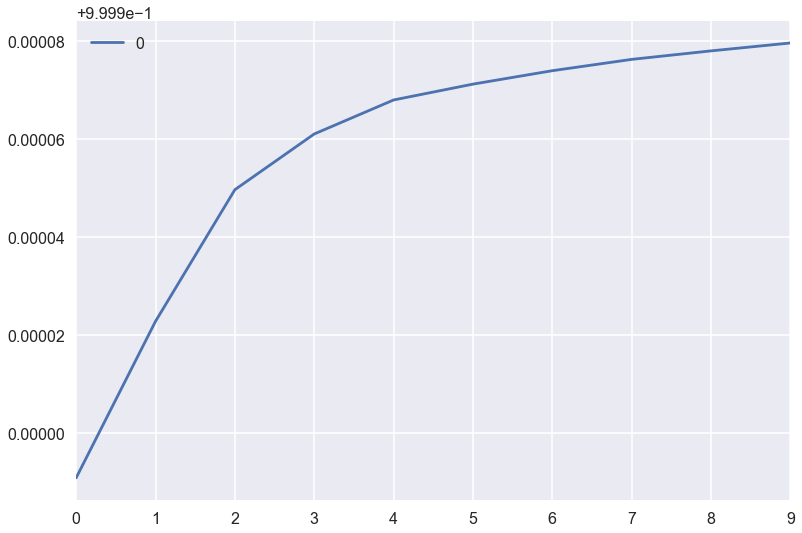

In [14]:
pd.DataFrame(np.cumsum(svd.explained_variance_ratio_)).plot()

# Clustering with KMeans

Because of the size of the dataset I will be using a sample of 5,000 participants.

In [15]:
embc = pd.DataFrame(embedded_coords)
samples = embc.sample(n=7)
outta = embc.sample(n=5000)

In [16]:
embc1 = pd.DataFrame(embedded_coords1)
samples1 = embc1.sample(n=7)
outta1 = embc1.sample(n=5000)

We´ll run a silhouette_score to decide the amount of clusters.

In [67]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

cluster_range = list(range(2,10)) 
#Go through with different n_components to find the best silhouette score

for n_cluster in cluster_range:
    # Apply your clustering algorithm of choice to the reduced data 
    clusterer = KMeans(n_cluster, random_state=2).fit(outta)
    
    # Predict the cluster for each data point
    preds = clusterer.predict(outta)
      
    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(outta, preds)
    
    print "The score for n_cluster = {}. is : {}". format(n_cluster, score)

The score for n_cluster = 2. is : 0.924793600267
The score for n_cluster = 3. is : 0.853751177099
The score for n_cluster = 4. is : 0.818092937943
The score for n_cluster = 5. is : 0.723393156292
The score for n_cluster = 6. is : 0.722852940232
The score for n_cluster = 7. is : 0.723593048971
The score for n_cluster = 8. is : 0.649740119197
The score for n_cluster = 9. is : 0.650874045216


In [68]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

cluster_range = list(range(2,10)) 
#Go through with different n_components to find the best silhouette score

for n_cluster in cluster_range:
    # Apply your clustering algorithm of choice to the reduced data 
    clusterer = KMeans(n_cluster, random_state=2).fit(outta1)
    
    # Predict the cluster for each data point
    preds = clusterer.predict(outta1)
      
    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(outta1, preds)
    
    print "The score for n_cluster = {}. is : {}". format(n_cluster, score)

The score for n_cluster = 2. is : 0.919903090028
The score for n_cluster = 3. is : 0.841432646928
The score for n_cluster = 4. is : 0.810123854254
The score for n_cluster = 5. is : 0.73977381994
The score for n_cluster = 6. is : 0.695709172959
The score for n_cluster = 7. is : 0.660463999629
The score for n_cluster = 8. is : 0.642144803125
The score for n_cluster = 9. is : 0.640995548479


#### How many clusters?
They all get pritty high scores but the silhouette score is the highest for 2 clusters and therefore we´ll use that.

We´ll run KMeans to group our participants into the clusters.

In [69]:
%%time

n_clusters = 2
km = KMeans(n_clusters)
clusters = km.fit_predict(outta)
labels = km.labels_

CPU times: user 110 ms, sys: 4.07 ms, total: 114 ms
Wall time: 70.9 ms


In [70]:
%%time

n_clusters = 2
km = KMeans(n_clusters)
clusters1 = km.fit_predict(outta1)
labels1 = km.labels_

CPU times: user 130 ms, sys: 3.8 ms, total: 134 ms
Wall time: 93.1 ms


Now we´ll run TSNE to get coordinates for our scatterplots. TSNE converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. 

In [52]:
%%time

result = TSNE(n_components=2, random_state=0).fit_transform(outta)
print result

[[ -9.441757     8.71859683]
 [ 11.01705007   9.72268937]
 [-12.07432552  -5.40000339]
 ..., 
 [ -8.37500122   8.07572557]
 [  0.72868558  10.23846758]
 [ -8.27212133   1.84404806]]
CPU times: user 1min 25s, sys: 9.62 s, total: 1min 34s
Wall time: 1min 39s


In [53]:
%%time

result1 = TSNE(n_components=2, random_state=0).fit_transform(outta1)
print result1

[[  5.31629692  -4.8081262 ]
 [  2.77403597   1.81083972]
 [ -1.93661207  -4.26413674]
 ..., 
 [ -1.35206054  -0.61083421]
 [ 12.55117567  -2.13686242]
 [  9.88132615   5.9263013 ]]
CPU times: user 1min 20s, sys: 9.56 s, total: 1min 30s
Wall time: 1min 36s


For comparison, we plot both the svd and the t-sne.

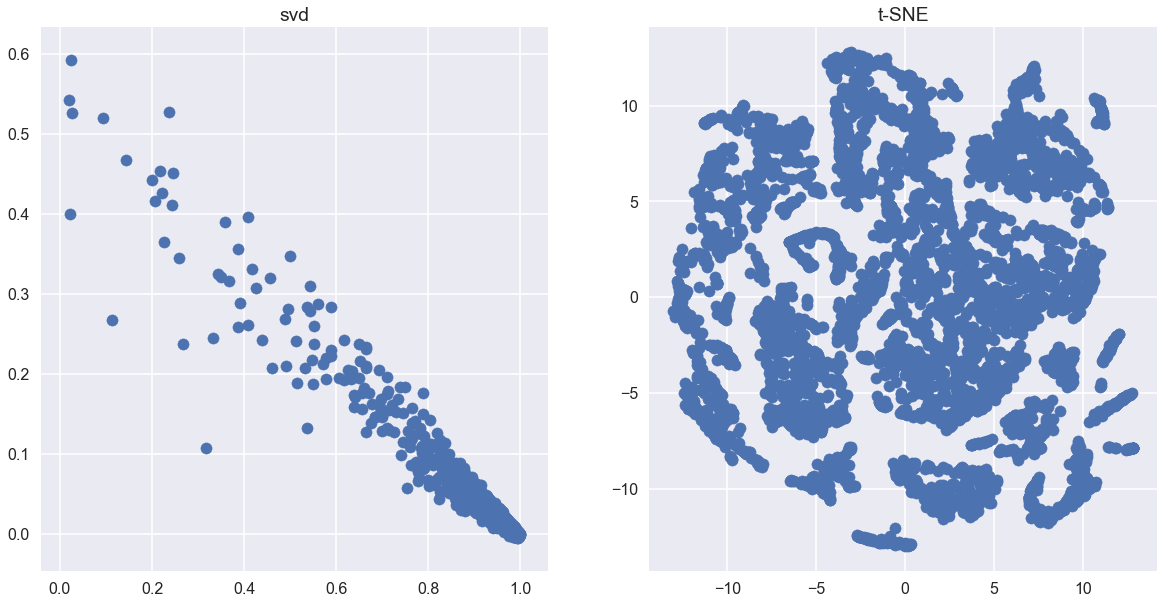

In [61]:
fig = plt.figure(figsize=(20,10))
plt.subplot2grid((1,2), (0,0))
plt.title('svd')
plt.scatter(outta[0], outta[1])
plt.subplot2grid((1,2), (0,1), rowspan=1, colspan=2)
plt.title('t-SNE')
plt.scatter(result[:,0], result[:,1])
plt.show()

## Scatterplots
As we can see on the scatterplots, in both cases, there are two clusters and in both cases the second cluster is significantly smaller than the other.

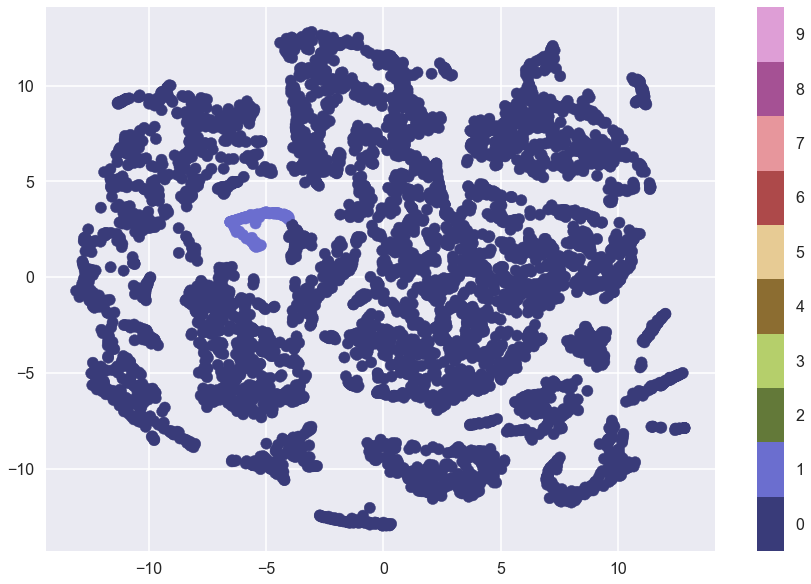

In [54]:
plt.figure(figsize=(15,10))
plt.scatter(result[:,0], result[:,1], c=labels, cmap=plt.cm.get_cmap("Vega20b", 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.show()

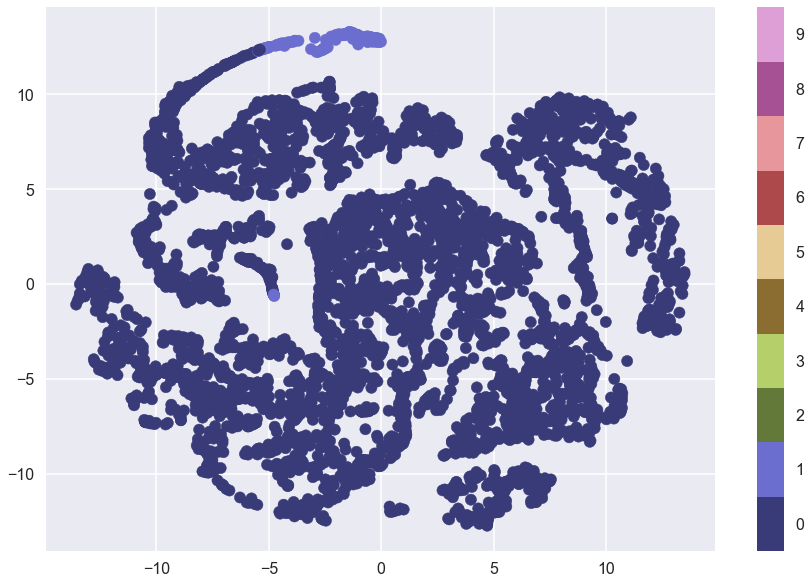

In [64]:
plt.figure(figsize=(15,10))
plt.scatter(result1[:,0], result1[:,1], c=labels1, cmap=plt.cm.get_cmap("Vega20b", 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.show()

# So wazz up?

#### I think it is safe to say that by the result of these clustering, people cannot be categorized by how they spend they'r days.

In [60]:
#import bokeh.plotting as bp
#from bokeh.models import HoverTool 
#from bokeh.charts import Scatter, output_file, show
#from bokeh.sampledata.autompg import autompg as df

#bp.output_notebook()

In [59]:
#colormap = np.array([
    #"#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c", 
    #"#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5", 
    #"#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f", 
    #"#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5"
#])

#bp.figure(plot_width=900, plot_height=700,  title="Subreddit Map by Interesting Dimensions",
       #x_axis_label = ,
       #y_axis_label = ,
       #tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
       #min_border=1)
#Scatter(outta[1], outta[2], color=colormap) 

#Scatter.show()